In [1]:
from backtesting.test import SMA
import pandas as pd
import glob

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
C:\Users\HP\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
filename = "NFO_NIFTYBANK_Future"
glob.glob(f"{filename}*.csv")

['NFO_NIFTYBANK_Future_Dec2023.csv',
 'NFO_NIFTYBANK_Future_Feb2024.csv',
 'NFO_NIFTYBANK_Future_Jan2024.csv',
 'NFO_NIFTYBANK_Future_Mar2024.csv']

In [3]:
all_csv_files = glob.glob(f"{filename}*.csv")

# read all csv files at once
df = pd.concat(pd.read_csv(csv_file) for csv_file in all_csv_files)
df.shape

(28549, 14)

In [4]:
df1 = df[['datetime','open','high','low','close','volume']]

In [5]:
df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")

C:\Users\HP\AppData\Local\Temp\ipykernel_10540\1482150303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")


In [6]:
data = df1.set_index('datetime')
data.rename(columns = {"open": "Open", "high": "High", "low":"Low", "close": "Close"}, inplace = True)

In [7]:
data

,Open,High,Low,Close,volume
datetime,,,,,
2023-12-01 09:15:00,44791.45,44836.85,44762.70,44823.35,41880
2023-12-01 09:16:00,44824.95,44827.95,44788.00,44827.95,27615
2023-12-01 09:17:00,44830.00,44837.15,44813.50,44832.00,25620
2023-12-01 09:18:00,44839.90,44865.00,44839.90,44865.00,23415
2023-12-01 09:19:00,44870.00,44875.00,44856.00,44875.00,14250
...,...,...,...,...,...
2024-03-27 15:25:00,46786.35,46786.35,46782.15,46785.85,29700
2024-03-27 15:26:00,46785.85,46790.00,46784.55,46786.50,19065
2024-03-27 15:27:00,46786.70,46789.00,46786.70,46788.95,16590


In [18]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
sma200 = SMA(data.Close, 200)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close
data['X_SMA200'] = (close - sma200) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close
data['X_DELTA_SMA100'] = (sma100 - sma200) / close


# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2024-03-15', '2024-03-30')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [9]:
data.head(2)

,Open,High,Low,Close,volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_SMA200,...,X_DELTA_SMA20,X_DELTA_SMA50,X_DELTA_SMA100,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2023-12-01 12:34:00,45101.8,45119.0,45097.95,45110.0,1320.0,0.000130,0.000118,-0.000369,-0.000493,0.000304,...,-0.000488,-0.000123,0.000797,0.000213,0.000140,-0.000377,0.000517,1.0,4.0,12.0
2023-12-01 12:35:00,45110.0,45135.0,45109.15,45124.2,2955.0,0.000396,0.000428,-0.000042,-0.000183,0.000585,...,-0.000470,-0.000140,0.000768,0.000582,-0.000098,-0.000721,0.000624,1.0,4.0,12.0


In [19]:
data['X_Sentiment'].value_counts()   
# 1.0 - > return is positive
# 0.0 -> retunr is around zero
# -1 -> return is negative 


X_Sentiment
1.0    25158
0.0     2993
Name: count, dtype: int64

In [20]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.9258709631828139


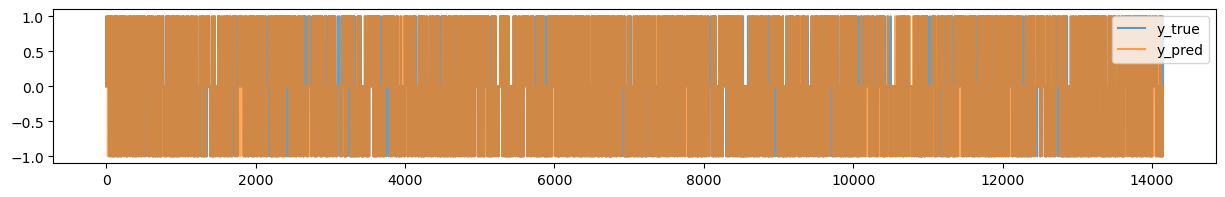

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(3)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [13]:
y_test, y_pred

(array([0., 1., 0., ..., 1., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]))

In [14]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'volume', 'X_SMA10', 'X_SMA20',
       'X_SMA50', 'X_SMA100', 'X_SMA200', 'X_DELTA_SMA10', 'X_DELTA_SMA20',
       'X_DELTA_SMA50', 'X_DELTA_SMA100', 'X_MOM', 'X_BB_upper', 'X_BB_lower',
       'X_BB_width', 'X_Sentiment', 'X_day', 'X_hour'],
      dtype='object')

In [21]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(3)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_10540\2381857173.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_10540\2381857173.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-12-04 09:38:00
End                       2024-03-27 15:29:00
Duration                    114 days 05:51:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                  1.7651
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

Classification accuracy:  0.926338102808691


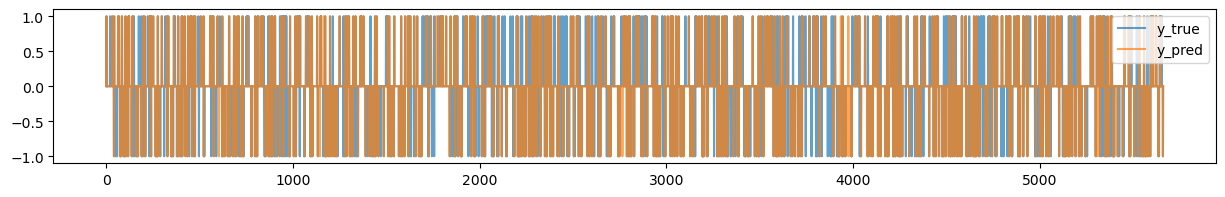

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

clf = RandomForestClassifier(50)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [17]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = RandomForestClassifier(50)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_10540\430983043.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_10540\430983043.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-12-01 12:34:00
End                       2024-03-27 15:29:00
Duration                    117 days 02:55:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                3.709488
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    